# Police API Demo

The https://data.police.uk/docs/ website provides an API — an *application programming interface* — that allows us to write programmatic code that can be used to query and download data from the website directly (that is, at a "machine to machine" level).

A Pyhton package exists that "wraps" this API and allows us to call it from Python code: https://github.com/rkhleics/police-api-client-python ([docs](https://police-api-client-python.readthedocs.io/en/latest/)).

## Using the API

Let's see how to use the API to download all the data for a particular year in a particular policie neighbourhood area.

In [25]:
#Initialisation
from police_api import PoliceAPI
api = PoliceAPI()

In [26]:
#Get forces
forces = api.get_forces()
forces

[<Force> Avon and Somerset Constabulary,
 <Force> Bedfordshire Police,
 <Force> Cambridgeshire Constabulary,
 <Force> Cheshire Constabulary,
 <Force> City of London Police,
 <Force> Cleveland Police,
 <Force> Cumbria Constabulary,
 <Force> Derbyshire Constabulary,
 <Force> Devon & Cornwall Police,
 <Force> Dorset Police,
 <Force> Durham Constabulary,
 <Force> Dyfed-Powys Police,
 <Force> Essex Police,
 <Force> Gloucestershire Constabulary,
 <Force> Greater Manchester Police,
 <Force> Gwent Police,
 <Force> Hampshire Constabulary,
 <Force> Hertfordshire Constabulary,
 <Force> Humberside Police,
 <Force> Kent Police,
 <Force> Lancashire Constabulary,
 <Force> Leicestershire Police,
 <Force> Lincolnshire Police,
 <Force> Merseyside Police,
 <Force> Metropolitan Police Service,
 <Force> Norfolk Constabulary,
 <Force> North Wales Police,
 <Force> North Yorkshire Police,
 <Force> Northamptonshire Police,
 <Force> Northumbria Police,
 <Force> Nottinghamshire Police,
 <Force> Police Service of

Each force has several atributes associated with it.

The items that are returned are a little confusing to work with. Let's make them more directly useable:

In [27]:
def getIdName(records, name=None):
    ''' Get id force by name. If no name, return a dict of name:id mappings. '''
    if name:
        return {r.name:r.id for r in records if name.lower() in r.name.lower()}
    return {r.name:r.id for r in records}

In [28]:
getIdName(forces)

{'Avon and Somerset Constabulary': 'avon-and-somerset',
 'Bedfordshire Police': 'bedfordshire',
 'Cambridgeshire Constabulary': 'cambridgeshire',
 'Cheshire Constabulary': 'cheshire',
 'City of London Police': 'city-of-london',
 'Cleveland Police': 'cleveland',
 'Cumbria Constabulary': 'cumbria',
 'Derbyshire Constabulary': 'derbyshire',
 'Devon & Cornwall Police': 'devon-and-cornwall',
 'Dorset Police': 'dorset',
 'Durham Constabulary': 'durham',
 'Dyfed-Powys Police': 'dyfed-powys',
 'Essex Police': 'essex',
 'Gloucestershire Constabulary': 'gloucestershire',
 'Greater Manchester Police': 'greater-manchester',
 'Gwent Police': 'gwent',
 'Hampshire Constabulary': 'hampshire',
 'Hertfordshire Constabulary': 'hertfordshire',
 'Humberside Police': 'humberside',
 'Kent Police': 'kent',
 'Lancashire Constabulary': 'lancashire',
 'Leicestershire Police': 'leicestershire',
 'Lincolnshire Police': 'lincolnshire',
 'Merseyside Police': 'merseyside',
 'Metropolitan Police Service': 'metropolita

In [29]:
getIdName(forces, 'Hampshire')

{'Hampshire Constabulary': 'hampshire'}

In [30]:
#Get police authority
force = api.get_force('hampshire')


In [31]:
def getNameId(records, rid=None):
    ''' Get record name by id. '''
    if rid:
        return {r.name:r.id for r in records if rid == r.id}
    return {r.name:r.id for r in records}

In [32]:
areas = getNameId(force.neighbourhoods)
areas

{'Aldershot North': '14RA01',
 'Aldershot South': '14RA02',
 'Alton': '8OL01',
 'Alton Rural': '8OL02',
 'Andover East': '11TA04',
 'Andover North': '11TA02',
 'Andover South': '11TA03',
 'Andover Town': '11TA01',
 'Bargate': '2SC02',
 'Barncroft and Bedhampton': '7JH02',
 'Basingstoke Centre': '12BB02',
 'Basingstoke East': '12BB05',
 'Basingstoke North': '12BB03',
 'Basingstoke Rural East': '12BL02',
 'Basingstoke Rural South': '12BL01',
 'Basingstoke Rural West': '12BL03',
 'Basingstoke South': '12BB01',
 'Basingstoke West': '12BB04',
 'Battins and West Leigh': '7JH03',
 'Bevois': '2SC01',
 'Bishops Waltham and Soberton': '9WG02',
 'Bitterne North': '2SN02',
 'Bordon': '8OW02',
 'Butser Clanfield Rowlands Castle': '8OP02',
 'Central Southsea and St Jude': '5PS02',
 'Charles Dickens and Nelson': '5PC01',
 'Cosham': '5PN01',
 'Cowes': '6LW01',
 'Coxford Redbridge Millbrook': '2SW02',
 'Crofton and Titchfield': '3FP01',
 'Denmead and Southwick': '9WG05',
 'East Cowes and Wootton': '6LE

In [33]:
#Show dates available
print( api.get_dates() )

['2019-01', '2018-12', '2018-11', '2018-10', '2018-09', '2018-08', '2018-07', '2018-06', '2018-05', '2018-04', '2018-03', '2018-02', '2018-01', '2017-12', '2017-11', '2017-10', '2017-09', '2017-08', '2017-07', '2017-06', '2017-05', '2017-04', '2017-03', '2017-02', '2017-01', '2016-12', '2016-11', '2016-10', '2016-09', '2016-08', '2016-07', '2016-06', '2016-05', '2016-04', '2016-03', '2016-02']


Via the police API, we can get retrieve a range of information about each neighbourghood.

In [34]:
neighbourhood = force.get_neighbourhood( areas['Ryde'] )
neighbourhood.priorities

[<Neighbourhood.Priority> <p>Violence<br />The North East Wight Team are focusing on reducing Violent Crime, part of this focus will be identifying and protecting persons suffering from domestic abuse.</p>
 
 <p>North East Wight<br />Station Street<br />Ryde<br />Isle of Wight<br />PO33 2QH</p>,
 <Neighbourhood.Priority> <p>ASB<br />The North East Wight team are focusing on tackling ASB Related issues, with a particular focus on any area's identified as being subject to drug related harm. </p>
 
 <p>Station Street<br />Ryde<br />Isle of Wight<br />PO33 2QH</p>,
 <Neighbourhood.Priority> <p>Burglary<br />The North East Wight Neighbourhood team are focusing on tackling Burglaries in the area. This forms part of an Island wide initiative to reduce Burglaries across the Island. </p>
 
 <p>North East Wight<br />Station Street<br />North East Wight<br />Ryde<br />Isle of Wight<br />PO33 2QH</p>,
 <Neighbourhood.Priority> <p>ASB<br />Reduce the speed and noise of vehicle enthusiasts along the

*If we associate output areas with neighbourhoods, we could also use the OA Rural Urban Classification codes to characterise each police neighbourhood.*

To look-up crimes within a particular neighbourhood, we can search within a particular area described by a simple boundary definition list (a closed list of points defining an area).

The data returned by the `get_neighbourhood()` lookup includes a boundary file in the required format for the particular area:

In [35]:
boundary = neighbourhood.boundary

The `boundary` object takes the form of a list of 2-tuples forming a closed shape: `[(lat0, lon0), (lat1, lon1), ..., (lat0, lon0),]`.

We can plot that boundary using folium if we cast it into the correct form.

In particular, we need to convert the list of lat/lon co-ordinates to a set of lon/lat co-ordinates inside a geojson data structure that folium can work with.

(Getting the correct order for co-ordinates can be a pain, with different packages and formats adopting different conventions. A handy summary can be found [here](https://macwright.org/lonlat/).)

In [36]:
def geoJsonFromNeighbourhoodBoundary(boundary):
    ''' Generate geojson polygon from police API boundary. '''
    geojson = {"type": "FeatureCollection",
               "features": [
                   {
                       "type": "Feature",
                       "properties": {},
                       "geometry": {
                           "type": "Polygon",
                           "coordinates":  [[[ll[1],ll[0]] for ll in boundary]]
                       }
                   }
               ]
              }
    return geojson
#geojson

In [37]:
import folium
import json

m = folium.Map(
    location=boundary[0], #Just pick the first point in boundary to centre map - rough and ready!
    #Note that the default location is in lat/lon order
    tiles='Mapbox Bright',
    zoom_start=11
)

folium.GeoJson(
    geoJsonFromNeighbourhoodBoundary(boundary),
    name='geojson'
).add_to(m)

m

We can easily build up a simple interactive application to allow a user to select a particular neighbourhood from a particular police force area.

In [38]:
#It would be better if this function were a little bit more sensitive to setting bounds on the map viewport
#folium does have a method for this, m.fit_bounds(), that takes bounding box co-ords.
#Generate bounding box from area extrema.
#https://github.com/python-visualization/folium/blob/master/folium/folium.py#L383

def createFoliumMap(boundary):
    m = folium.Map(
        location=boundary[0], #Just pick the first point in boundary to centre map - rough and ready!
        #Note that the default location is in lat/lon order
        #tiles='Mapbox Bright',
        zoom_start=11
    )

    folium.GeoJson(
        geoJsonFromNeighbourhoodBoundary(boundary),
        name='geojson'
    ).add_to(m)

    return m

In [39]:
from ipywidgets import widgets, interact


#Note that we are seeding both widgets with values from the API

force_widget = widgets.Select(options=getIdName(forces),
                              description='Police Force:',
                              disabled=False )

area_widget = widgets.Select(options=getNameId(force.neighbourhoods),
                              description='Neigbourhood areas:',
                              disabled=False )

def update_area_widget(*args):
    ''' Update neighbourhoods widget. Also update the force global variable. '''
    global force
    force = api.get_force(force_widget.value)
    area = getNameId(force.neighbourhoods)
    area_widget.options = getNameId(force.neighbourhoods)
    
force_widget.observe(update_area_widget, 'value')

def mapper(force_i, area_i):
    ''' Generate map for selected area. Also set global boundary for use elsewhere. '''
    global boundary
    neighbourhood = force.get_neighbourhood( area_widget.value )
    boundary = neighbourhood.boundary
    m = createFoliumMap(boundary)
    print(force_i, area_i)
    return m
    
interact(mapper,force_i=force_widget, area_i=area_widget);


interactive(children=(Select(description='Police Force:', options={'Avon and Somerset Constabulary': 'avon-and…

*This sort of thing can be served as a standalone from a notebook source file using things like [voila](https://github.com/QuantStack/voila) or [Jupyter dashboards](https://github.com/jupyter/dashboards). Conversion to [Scripted Forms](https://github.com/SimonBiggs/scriptedforms) format is another option, although that would require a small amount of recoding using Scripted Forms markup.*

## Get crimes in an area

We can use the API to retrieve crimes recorded within a particular area for a particular time period.

In [40]:
crimes = api.get_crimes_area(neighbourhood.boundary, date='2019-01')


In [41]:
#Unpack location details
crimes[0].location.id, crimes[0].location.latitude, crimes[0].location.longitude, crimes[0].location.name


(763767, '50.727222', '-1.162537', 'On or near Supermarket')

In [42]:
#Upack category details
crimes[0].category.id, crimes[0].category.name

('anti-social-behaviour', 'Anti-social behaviour')

In [43]:
import pandas as pd


def setCrimesAsDataFrame(crimes, df=None):
    ''' Convert crimes result to dataframe. '''
    if df is None:
        df=pd.DataFrame(columns = ['cid','type', 'month','name','lid','location','lat','lon'])
        #[int, object, object, int, object, float, float]
    for c in crimes:
        df = df.append({'cid':c.id,'type':c.category.id, 'month':c.month, 'name':c.category.name,
                            'lat':c.location.latitude,'lon':c.location.longitude, 
                        'lid':c.location.id,'location':c.location.name }, ignore_index=True)

    df['lat']=df['lat'].astype(float)
    df['lon']=df['lon'].astype(float)
    
    return df

In [44]:
df = setCrimesAsDataFrame(crimes)
df.head()

,cid,type,month,name,lid,location,lat,lon
0,71249494,anti-social-behaviour,2019-01,Anti-social behaviour,763767,On or near Supermarket,50.727222,-1.162537
1,71249516,anti-social-behaviour,2019-01,Anti-social behaviour,763719,On or near West Place,50.726292,-1.167016
2,71249593,anti-social-behaviour,2019-01,Anti-social behaviour,763566,On or near Sutton Close,50.718427,-1.152494
3,71249583,anti-social-behaviour,2019-01,Anti-social behaviour,763545,On or near Slade Road,50.720485,-1.156055
4,71249466,anti-social-behaviour,2019-01,Anti-social behaviour,763785,On or near George Street,50.728725,-1.161490


## Plot Crimes on Map

As in *Initial Look At The Data.ipynb*, we can plot the crime markers on a map or create a heatmap.

In [45]:
#Recall that the Heatmap plugin expects data in the form [[Latitude, Longitude, count], ...]

data = df.groupby(['lat','lon']).size().reset_index().values.tolist()
data[:3]

[[50.716306, -1.151484, 3.0],
 [50.718427, -1.152494, 4.0],
 [50.719642, -1.147698, 1.0]]

In [46]:
from folium.plugins import HeatMap

m = folium.Map(data[0][:2], zoom_start=12)


HeatMap(data).add_to(m)

m

We can then select an area, and crime type, to generate a heatmap from:

In [47]:
crime_types = df[['name','type']].drop_duplicates().set_index('name')['type'].to_dict()
crime_types

{'Anti-social behaviour': 'anti-social-behaviour',
 'Bicycle theft': 'bicycle-theft',
 'Burglary': 'burglary',
 'Criminal damage and arson': 'criminal-damage-arson',
 'Drugs': 'drugs',
 'Other theft': 'other-theft',
 'Public order': 'public-order',
 'Robbery': 'robbery',
 'Shoplifting': 'shoplifting',
 'Violence and sexual offences': 'violent-crime',
 'Other crime': 'other-crime'}

For now, let's just use a fixed date. We could of course add in another widget to select the date too.

In [48]:
crime_widget = widgets.Select(options=crime_types,
                              description='Crime:',
                              disabled=False )


def crime_heatmap(force_i, area_i, crime_i):
    ''' Create a heatmap. '''
    m = mapper(force_i, area_i)
    
    crimes = api.get_crimes_area(boundary, date='2019-01')
    df = setCrimesAsDataFrame(crimes)
    df = df[df['type']==crime_i]
    data = df.groupby(['lat','lon']).size().reset_index().values.tolist()

    HeatMap(data).add_to(m)
    
    return m



interact(crime_heatmap,force_i=force_widget, area_i=area_widget, crime_i=crime_widget);

#Avon and Somerset, Aldershot South works..

interactive(children=(Select(description='Police Force:', options={'Avon and Somerset Constabulary': 'avon-and…

Or we can create a heatmap that is animated over several time periods.

To do this, we first need to obtain crime data recorded over several different months:

In [249]:
dates_2018 = [d for d in api.get_dates() if '2018' in d]
dates_2018

['2018-12',
 '2018-11',
 '2018-10',
 '2018-09',
 '2018-08',
 '2018-07',
 '2018-06',
 '2018-05',
 '2018-04',
 '2018-03',
 '2018-02',
 '2018-01']

We could collect the data into a single dataframe as:

In [250]:
crimes_2018= pd.DataFrame()

for d in dates_2018:
    tmp = api.get_crimes_area(boundary, date=d)
    crimes_2018 = pd.concat([crimes_2018, setCrimesAsDataFrame(tmp)])
    
crimes_2018.head()

,cid,type,month,name,lid,location,lat,lon
0,70396159,anti-social-behaviour,2018-12,Anti-social behaviour,783721,On or near Bus/coach Station,51.246634,-0.760871
1,70396058,anti-social-behaviour,2018-12,Anti-social behaviour,783804,On or near Commercial Road,51.241971,-0.749435
2,70396348,anti-social-behaviour,2018-12,Anti-social behaviour,783896,On or near Denmark Street,51.250450,-0.741812
3,70396181,bicycle-theft,2018-12,Bicycle theft,783655,On or near Parking Area,51.247843,-0.762902
4,70396330,burglary,2018-12,Burglary,783904,On or near Shopping Area,51.250790,-0.735727


However, the data needs to be presented as a list of lists: `[ data_period1, data_period2, etc. ]`.

So it may be easier (for now) to collect it as:

In [251]:
overall_data = []

for d in dates_2018:
    tmp_crimes = api.get_crimes_area(boundary, date=d)
    df = setCrimesAsDataFrame(tmp_crimes)
    period_data = df.groupby(['lat','lon']).size().reset_index().values.tolist()
    overall_data.append(period_data)

In [252]:
from folium.plugins import HeatMapWithTime

m = folium.Map(overall_data[0][0][:2], tiles='stamentoner', zoom_start=13)

HeatMapWithTime(overall_data).add_to(m)

m

## Plotting Choropleths

Another way of visualising the data is to use a choropleth map. However, this requires boundaries, rather than points, that can be filled with indicative colour values.

The Police API allows us to search for crimes within a particular boundary, so we could download shapefiles for a small geography (for example, [output area](http://geoportal.statistics.gov.uk/datasets/09b8a48426e3482ebbc0b0c49985c0fb_0)) and search for crimes withon those areas.

An alternative is to generate Voronoi boundaries around each of the crime points. (Ideally, we would have a database of all the legitimate crime recording points in a neighbourhood. (Locations are approximated to specific location points.))

There are several ways in which we can generate Voronoi boundaries (*notebook to follow*), but for convenience we will use the [WZBSocialScienceCenter/geovoronoi](https://github.com/WZBSocialScienceCenter/geovoronoi/) package.

*ASIDE: [spatialite will create voronoi boundaries](https://www.gaia-gis.it/fossil/libspatialite/wiki?name=tesselations-4.0); other py examples with a lower level look can be found [here](https://gist.github.com/Sklavit/e05f0b61cb12ac781c93442fbea4fb55), [here](https://github.com/GrayTaylor/voronoi/blob/master/Voronoi%20for%20tableau.ipynb) and [here](https://stackoverflow.com/questions/23901943/voronoi-compute-exact-boundaries-of-every-region/52727406#52727406).*

One of the example recipes for using the `geovoronoi` packages works on a geopandas dataframe, so let's convert the crimes dataframe to a geopandas dataframe.

*(The recipe actually converts co-ordinates in the geodataframe representation back to an array that is closer to our original list of points, but it is nevertheless instructive to show how we can generate a geopandas dataframe.)*

In [253]:
#For a particular crime type, get the count of crimes by location
crimes = setCrimesAsDataFrame( api.get_crimes_area(boundary, date='2019-01') )
public_order_crime = crimes[crimes['type']=='public-order']
public_order_crime_count_by_location = public_order_crime.groupby(['lat','lon']).size().to_frame('Count').reset_index()
public_order_crime_count_by_location.head()

,lat,lon,Count
0,51.235960,-0.754870,1
1,51.237927,-0.742956,1
2,51.242522,-0.740438,1
3,51.243125,-0.760708,1
4,51.245092,-0.763821,1


In [254]:
#For convenience, let's go back to using the df name...
df = public_order_crime_count_by_location.reset_index()

Cast the dataframe as a geodataframe with a suitable geometry column:

In [255]:
#https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
import geopandas
from shapely.geometry import Point

df['Coordinates'] = list(zip(df['lon'], df['lat']))
df['Coordinates'] = df['Coordinates'].apply(Point)

df['RCoordinates'] = list(zip(df['lat'], df['lon']))
df['RCoordinates'] = df['RCoordinates'].apply(Point)
gdf = geopandas.GeoDataFrame(df, geometry='Coordinates')

#Avoid ambiguity about whether index is int or string
gdf['index'] = gdf['index'].apply(lambda x: 'a_{}'.format(x))

gdf.head()

,index,lat,lon,Count,Coordinates,RCoordinates
0,a_0,51.235960,-0.754870,1,POINT (-0.75487 51.23596),POINT (51.23596 -0.75487)
1,a_1,51.237927,-0.742956,1,POINT (-0.7429559999999999 51.237927),POINT (51.237927 -0.7429559999999999)
2,a_2,51.242522,-0.740438,1,POINT (-0.740438 51.242522),POINT (51.242522 -0.740438)
3,a_3,51.243125,-0.760708,1,POINT (-0.7607080000000001 51.243125),POINT (51.243125 -0.7607080000000001)
4,a_4,51.245092,-0.763821,1,POINT (-0.763821 51.245092),POINT (51.245092 -0.763821)


In [256]:
gdf.crs = {'init' :'epsg:4326 '}
gdf.crs

{'init': 'epsg:4326 '}

We also need the boundary as a shapefile:

In [257]:
#Check how the boundary co-ordinates are presented
boundary[:2]
#Looks like: lat, lon

[(51.233892739925, -0.75875030165815), (51.233827752428, -0.75838823059195)]

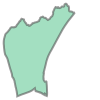

In [258]:
from shapely import geometry

#By default, I think shapely shapes assume lon/lat format...
#So this shape is rotated in preview...
boundary_shape_rotated = geometry.Polygon(boundary)
boundary_shape_rotated

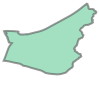

In [259]:
boundary_shape = geometry.Polygon( [(lon,lat) for (lat,lon) in boundary] )
boundary_shape

Now let's see how to create the Voronoi boundaries

In [260]:
#https://github.com/WZBSocialScienceCenter/geovoronoi/blob/master/examples/using_geopandas.py

from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords


# convert the pandas Series of Point objects to NumPy array of coordinates
coords = points_to_coords(gdf.Coordinates)
Rcoords = points_to_coords(gdf.RCoordinates)

# Calculate the Voronoi regions for the identifed points and then 
# clip within the geographic area shape
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, boundary_shape)

Sometimes we may get an error of the form `no polygonal hull of far points could be created`, in which case, see the section *Coping with Voronoi Errors...* below.

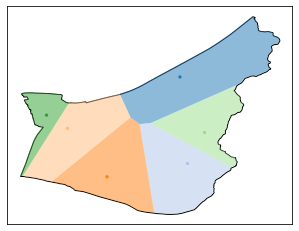

In [261]:
#Preview the shapes

fig, ax = subplot_for_map()

plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments);


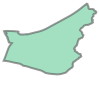

In [262]:
boundary_shape

The `polyshapes` object is a list of boundaries for the Voronoi areas, associated with particular points. In general, we might have multiple rows in the original table associated with each shape (the mappings are decribed as a list in `poly_to_pt_assignments`) but in this case we ensured unique locations in the dataframe. 

The Voronoi shaper returns items in the same order they were presented, so we can merge the data back:

In [263]:
gdf['voronoi_boundary'] = poly_shapes

gdf = gdf.set_geometry('voronoi_boundary')

gdf.head()

,index,lat,lon,Count,Coordinates,RCoordinates,voronoi_boundary
0,a_0,51.235960,-0.754870,1,POINT (-0.75487 51.23596),POINT (51.23596 -0.75487),POLYGON ((-0.7484216807095689 51.2439095372201...
1,a_1,51.237927,-0.742956,1,POINT (-0.7429559999999999 51.237927),POINT (51.237927 -0.7429559999999999),POLYGON ((-0.7500399123311127 51.2437691398133...
2,a_2,51.242522,-0.740438,1,POINT (-0.740438 51.242522),POINT (51.242522 -0.740438),POLYGON ((-0.7630546270874882 51.2352520979153...
3,a_3,51.243125,-0.760708,1,POINT (-0.7607080000000001 51.243125),POINT (51.243125 -0.7607080000000001),POLYGON ((-0.751390504638194 51.24475595651392...
4,a_4,51.245092,-0.763821,1,POINT (-0.763821 51.245092),POINT (51.245092 -0.763821),POLYGON ((-0.7604620009405411 51.2469611586538...


We should now be able to plot this as a choropleth map:

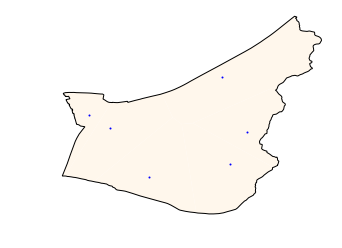

In [264]:
from descartes import PolygonPatch

ax = gdf.plot(column='Count', cmap='OrRd')
ax.add_patch(PolygonPatch(boundary_shape,fill=False))

gdf = gdf.set_geometry('Coordinates')
gdf[gdf['Count']>0].plot( ax=ax, markersize=1, c='b', marker='o')
ax.axis('off');

The shapes defined in geojson have to be just right for it to be plotted correctly.

It seems that the shapes returned by the `voronoi_regions_from_coords()` don't play nicely with folium, so if we want to plot them in folium we need to repair the geojson that the geodataframe `__geo_interface__` returns.

The following seems to do the trick...

In [265]:
import json
from geojson_rewind import rewind

gdf = gdf.set_geometry('voronoi_boundary')
rewoundGeoJSON = rewind( json.dumps(gdf.set_index('index')['voronoi_boundary'].__geo_interface__) )

In [266]:
def addMarker(m,row):
    folium.Circle([row['lat'], row['lon']], radius=1, color='red').add_to(m)
    
m =  folium.Map(zoom_start=12, location=gdf.iloc[0][['lat','lon']].tolist() )
folium.Choropleth(rewoundGeoJSON,#gdf[['index','Count','voronoi_boundary']],
                  key_on='id',
                  data=gdf, 
                  columns=['index','Count'],
            fill_color='YlOrBr').add_to(m)

#for i, r in gdf.iterrows():
#    folium.Circle([r['lat'], r['lon']], radius=1, color='red').add_to(m)
gdf.apply(lambda x: addMarker(m,x), axis=1)
m

### Coping with Voronoi Errors...

Sometimes when attempting to create a Voronoi diagram, we may get the error: `no polygonal hull of far points could be created`. For example, such an error occurs when trying to create a Voronoi diagram for the *Avon & Someset* neighbourhood of *Alton Rural*.

The following cell will show how the crime location points fall with the neighbourhood boundary.

For the case of *Alton Rural*, we see how the location markers are concentrated within a localised urban area rather than distributed across the whole neighbourhood area. In this case, we may wish to create a smaller boundary area within which we could try create a more reasonable area distribution.

In [153]:
m = createFoliumMap(boundary)
for p in points_to_coords(gdf.Coordinates):
    folium.Circle([p[1],p[0]], radius=1, color='red').add_to(m)
m

We could use a tool such as https://geojson.net/#12/51.1421/-0.9684 to draw our own boundary.

Generate a URL of the form https://geojson.net/#ZOOM_LEVEL/LAT/LONG, perhaps by previewing on of the points in our crime location dataset:

In [178]:
example_coords = gdf[['lat','lon']].iloc[0].values
print('https://geojson.net/#12/{}/{}'.format(example_coords[0],example_coords[1]))

https://geojson.net/#12/51.109576/-0.992514


Draw a boundary shape using the *geojson.net* editor, copy the associated JSON string and paste it below.

In [ ]:
#Paste your JSON data below so we can assign it to the jsondata variable
jsondata='''
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [-0.960474, 51.165091],
            [-0.988426, 51.154801],
            [-1.007309, 51.141879],
            [-0.971955, 51.135133],
            [-0.945854, 51.151786],
            [-0.960474, 51.165091]
          ]
        ]
      }
    }
  ]
}
'''

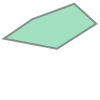

In [214]:
#If the json data is a FeatureCollection with a single features list item
# we can parse it as follows...
from shapely.geometry import shape

shape(json.loads(jsondata)['features'][0]['geometry'])

More generally, we can parse the JSON data into a geopandas dataframe:

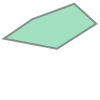

In [203]:
import json

#Load the geojson into a geopandas data frame and let it handle the conversion
boundary_shape2 =  geopandas.GeoDataFrame.from_features(json.loads(jsondata))['geometry'].iloc[0]
boundary_shape2

Now we need to filter the points to ones within the new boundary:

In [206]:
coords2= points_to_coords( [c for c in gdf.Coordinates if boundary_shape2.contains(c)] )
coords2

array([[-0.984213, 51.142874],
       [-0.973933, 51.142983],
       [-0.979022, 51.145563],
       [-0.975188, 51.146986],
       [-0.978655, 51.147295],
       [-0.980376, 51.147706],
       [-0.975925, 51.148557],
       [-0.979526, 51.148643],
       [-0.976809, 51.148682],
       [-0.967612, 51.151407],
       [-0.971456, 51.151513],
       [-0.966272, 51.156997]])

In [208]:
#Now we can have another go at finding the Voronoi boundaries
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords2, boundary_shape2)

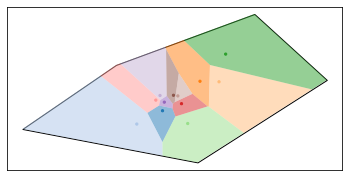

In [209]:
#Preview the shapes

fig, ax = subplot_for_map()

plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments);


In [ ]:
# TO DO -  explore ipyleaflet callbacks
#We should be able to draw on map and get shapefile back?
#https://gis.stackexchange.com/a/312462/119781

## Crimes Along a Route

As well as looking at crimes within an area, we could look at crimes along a route.

In [216]:
import osmnx as ox
import networkx as nx

In [217]:
#Get roads within a geographical area from OpenStreetmap
G = ox.graph_from_place('Newport, Isle of Wight, UK', network_type='walk')

In [218]:
origin = ox.utils.geocode("Bargeman's Rest, Newport, Isle of Wight")
destination = ox.utils.geocode('Prince of Wales, Newport, Isle of Wight')

origin_node =  ox.get_nearest_node(G, origin) 
destination_node = ox.get_nearest_node(G, destination )

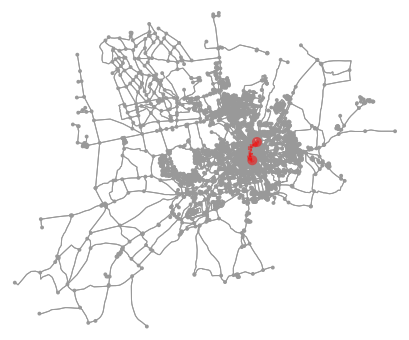

In [219]:
route = nx.shortest_path(G, origin_node, destination_node)
ox.plot_graph_route(G, route);

The route is provided as a set of nodes on the graph. But there is a convenience function...

In [220]:
#https://github.com/gboeing/osmnx-examples/blob/master/notebooks/11-plot-routes-folium-web-map.ipynb
route_map = ox.plot_route_folium(G, route, fit_bounds=True)
route_map

If we take a [peek inside that function](https://github.com/gboeing/osmnx/blob/master/osmnx/plot.py#L873) we can see how to get the geojson out:

In [221]:
from osmnx.save_load import graph_to_gdfs

In [222]:
gdf_edges = graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
route_nodes = list(zip(route[:-1], route[1:]))
index = [gdf_edges[(gdf_edges['u']==u) & (gdf_edges['v']==v)].index[0] for u, v in route_nodes]
gdf_route_edges = gdf_edges.loc[index]
gdf_route_edges.head()

,access,bridge,est_width,geometry,highway,junction,key,landuse,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
5999,NaN,NaN,NaN,"LINESTRING (-1.2914296 50.7027748, -1.2913958 ...",footway,NaN,0,NaN,NaN,13.180,NaN,NaN,False,562587775,NaN,NaN,NaN,5423445769,5423445782,NaN
6028,NaN,NaN,NaN,"LINESTRING (-1.2914488 50.7026772, -1.2915212 ...",footway,NaN,0,NaN,NaN,12.822,NaN,NaN,False,562587778,NaN,NaN,NaN,5423445782,5423445780,NaN
6025,NaN,NaN,NaN,"LINESTRING (-1.2915212 50.7025714, -1.2915438 ...",footway,NaN,0,NaN,NaN,9.856,NaN,NaN,False,562587778,NaN,NaN,NaN,5423445780,5424603613,NaN
388,NaN,NaN,NaN,"LINESTRING (-1.2915762 50.7024899, -1.2915329 ...",footway,NaN,0,NaN,NaN,7.428,NaN,NaN,False,312410800,NaN,NaN,NaN,5424603613,7394047,NaN
4951,NaN,NaN,NaN,"LINESTRING (-1.2914799 50.7024636, -1.2915156 ...",unclassified,NaN,0,NaN,NaN,117.382,30 mph,Little London,False,"[367895419, 436603100, 367895415]",NaN,NaN,NaN,7394047,7394036,NaN


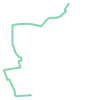

In [223]:
#Get the combined route
gdf_route_edges.unary_union

In [224]:
#Cribbing more of the osmnx .plot_route_folium() function
x, y = gdf_route_edges.unary_union.centroid.xy
route_centroid = (y[0], x[0])

In [225]:
#Fitter pinched from .plot_route_folium()
def fit_bounds(m, r ):
    tb = r.total_bounds
    bounds = [(tb[1], tb[0]), (tb[3], tb[2])]
    m.fit_bounds(bounds)

m = folium.Map(
    location=route_centroid,
    zoom_start=11
)

folium.GeoJson(
    gdf_route_edges.unary_union,
    name='geojson'
).add_to(m)


fit_bounds(m, gdf_route_edges)    

m

Now let's see if we can create a buffered area around the route:

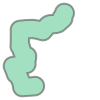

In [226]:
#I'm not sure what units describe the distance and resolution parameters?
buffered_route = gdf_route_edges.unary_union.buffer(distance = 0.0005, resolution=16)
buffered_route

In [227]:
m = folium.Map(
    location=route_centroid,
    zoom_start=11
)

folium.GeoJson(
    buffered_route,
    name='geojson'
).add_to(m)


folium.GeoJson(
    gdf_route_edges.unary_union,
    name='geojson',
    style_function = lambda x: {'color': 'red'}
).add_to(m)


fit_bounds(m, gdf_route_edges)  

m

In [228]:
#If we want to get the json out...
#buffered_json = json.dumps(buffered_route.__geo_interface__)

We should now be able to use this shape to run a query for crimes in the area, as long as we put the shape into the correct format: `[(lat0, lon0), (lat1, lon1), ..., (lat0, lon0),]`.

In [229]:
#Get the co-ords
lon, lat = buffered_route.exterior.coords.xy
buffer_boundary = list(zip(lat, lon))

#Preview
buffer_boundary[:3]

[(50.699885310650906, -1.29472664216953),
 (50.69989637114134, -1.2947266812059743),
 (50.69990979869374, -1.29472540654124)]

We can now try to search in this area...

In [232]:
crimes = api.get_crimes_area(buffer_boundary, date='2019-01')
df = setCrimesAsDataFrame(crimes)


In [233]:
from folium.plugins import MarkerCluster

marker_cluster = MarkerCluster().add_to(m)


icon_color_map={'Under investigation':'blue',
                'Unable to prosecute suspect':'purple',
                'Investigation complete; no suspect identified':'black',
                'Awaiting court outcome':'orange',
                'Further investigation is not in the public interest':'darkblue'
            }

icon_map={'Violence and sexual offences':('wrench','glyphicon'),
          'Public order':('beer', 'fa'),
          'Criminal damage and arson':('fire','fa'),
          'Other theft':('refresh','glyphicon'),
          'Burglary':('home','fa'),
          'Anti-social behaviour':('bullhorn','fa'),
          'Robbery':('usd','glyphicon'),
          'Possession of weapons':('fighter-jet','fa'),
          'Vehicle crime':('car','fa'),
          'Other crime':('question-sign','glyphicon'),
          'Drugs':('pushpin', 'glyphicon'),
          'Theft from the person':('user', 'glyphicon'),
          'Shoplifting':('shopping-cart','glyphicon')
}


def addIconMarker(m,loc):
    if loc['name'] in icon_map:
        icon, prefix = icon_map[loc['name']]
    else:
        icon,prefix='record','glyphicon'
    if 'Last outcome category' in loc and loc['Last outcome category'] and loc['Last outcome category'] in icon_color_map:
        color=icon_color_map[loc['Last outcome category']]
    else:
        color='grey'
    icon = folium.Icon(icon=icon, icon_color='white', color=color, prefix=prefix)
    folium.Marker([loc['lat'], loc['lon']],
                  icon=icon,
                  popup='{}<br/><br/>{}'.format(loc['name'],
                                                loc['location'])).add_to(marker_cluster)

df.apply(lambda x: addIconMarker(m,x), axis=1)

m

## Isochrones

Isochrone maps are equivalent travel time maps.

So we could look for crimes within a certain travel time of a location.


Note that isochrone maps take some time to calculate.

In [236]:
# add an edge attribute for time in minutes required to traverse each edge
travel_speed = 4.5

meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute

#Generate a temporal distance measure for each edge
# I wonder if we could also use this in a route planner?
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [237]:
trip_times = [5, 10, 15, 30] #in minutes
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

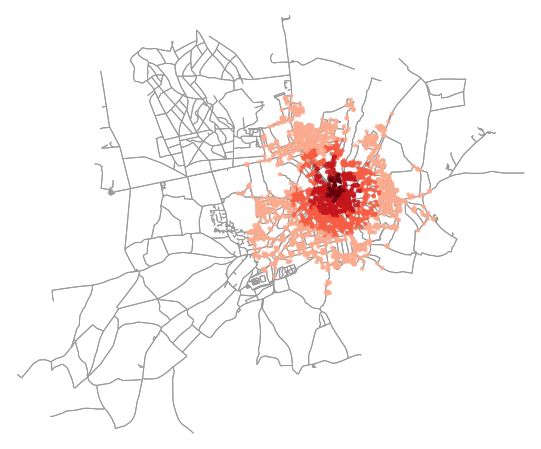

In [246]:
import networkx as nx

# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, origin_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2);

In [247]:
#Via Geoff Boeing: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb
from shapely.geometry import LineString, Polygon, Point
from descartes import PolygonPatch
import geopandas as gpd

def make_iso_polys(G, center_node, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

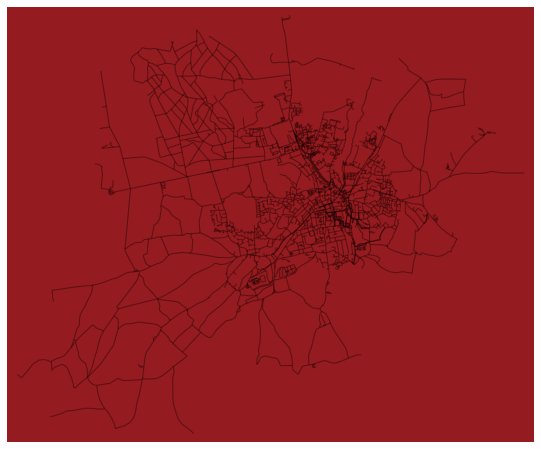

In [248]:
#Not working?

isochrone_polys = make_iso_polys(G, origin_node, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)


In [ ]:
# TO DO

# Show how we can create maps for areas using widget selectors

## Utils

In [ ]:
#WKT values from gdf
[g.wkt for g in gdf['Coordinates'].values]

In [159]:
#geoJSON fron gdf
print(json.dumps(gdf.Coordinates.__geo_interface__))

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": [-0.992514, 51.109576]}, "bbox": [-0.992514, 51.109576, -0.992514, 51.109576]}, {"id": "1", "type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": [-0.984213, 51.142874]}, "bbox": [-0.984213, 51.142874, -0.984213, 51.142874]}, {"id": "2", "type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": [-0.973933, 51.142983]}, "bbox": [-0.973933, 51.142983, -0.973933, 51.142983]}, {"id": "3", "type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": [-0.979022, 51.145563]}, "bbox": [-0.979022, 51.145563, -0.979022, 51.145563]}, {"id": "4", "type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": [-0.975188, 51.146986]}, "bbox": [-0.975188, 51.146986, -0.975188, 51.146986]}, {"id": "5", "type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordin